# How to generate a utility report?

### Check that the synthetic data preserve the information of the real data

Assume that the synthetic data is already generated \
Based on the Wisconsin Breast Cancer Dataset

In [1]:
# Standard library
import sys
import tempfile
from pathlib import Path

sys.path.append("..")

# 3rd party packages
import pandas as pd

# Local packages
import config
import utils.draw
from metrics.utility.report import UtilityReport

## Load the real and synthetic WBCD datasets

In [2]:
df_real = {}
df_real["train"] = pd.read_csv(
    "../data/" + config.WBCD_DATASET_TRAIN_FILEPATH.stem + ".csv"
)
df_real["test"] = pd.read_csv(
    "../data/" + config.WBCD_DATASET_TEST_FILEPATH.stem + ".csv"
)
df_real["train"].shape

(359, 10)

### Choose the synthetic dataset

In [3]:
df_synth = {}  # generated by Synthpop ordered here
df_synth["train"] = pd.read_csv("../results/data/2023-07-31_Synthpop_359samples.csv")
df_synth["test"] = pd.read_csv("../results/data/2023-07-31_Synthpop_90samples.csv")
df_synth["test"].shape

(90, 10)

## Configure the metadata dictionary

### The continuous and categorical variables need to be specified, as well as the variable to predict for the future learning task

In [4]:
metadata = {
    "continuous": [
        "Clump_Thickness",
        "Uniformity_of_Cell_Size",
        "Uniformity_of_Cell_Shape",
        "Marginal_Adhesion",
        "Single_Epithelial_Cell_Size",
        "Bland_Chromatin",
        "Normal_Nucleoli",
        "Mitoses",
        "Bare_Nuclei",
    ],
    "categorical": ["Class"],
    "variable_to_predict": "Class",
}

## Compare the distributions

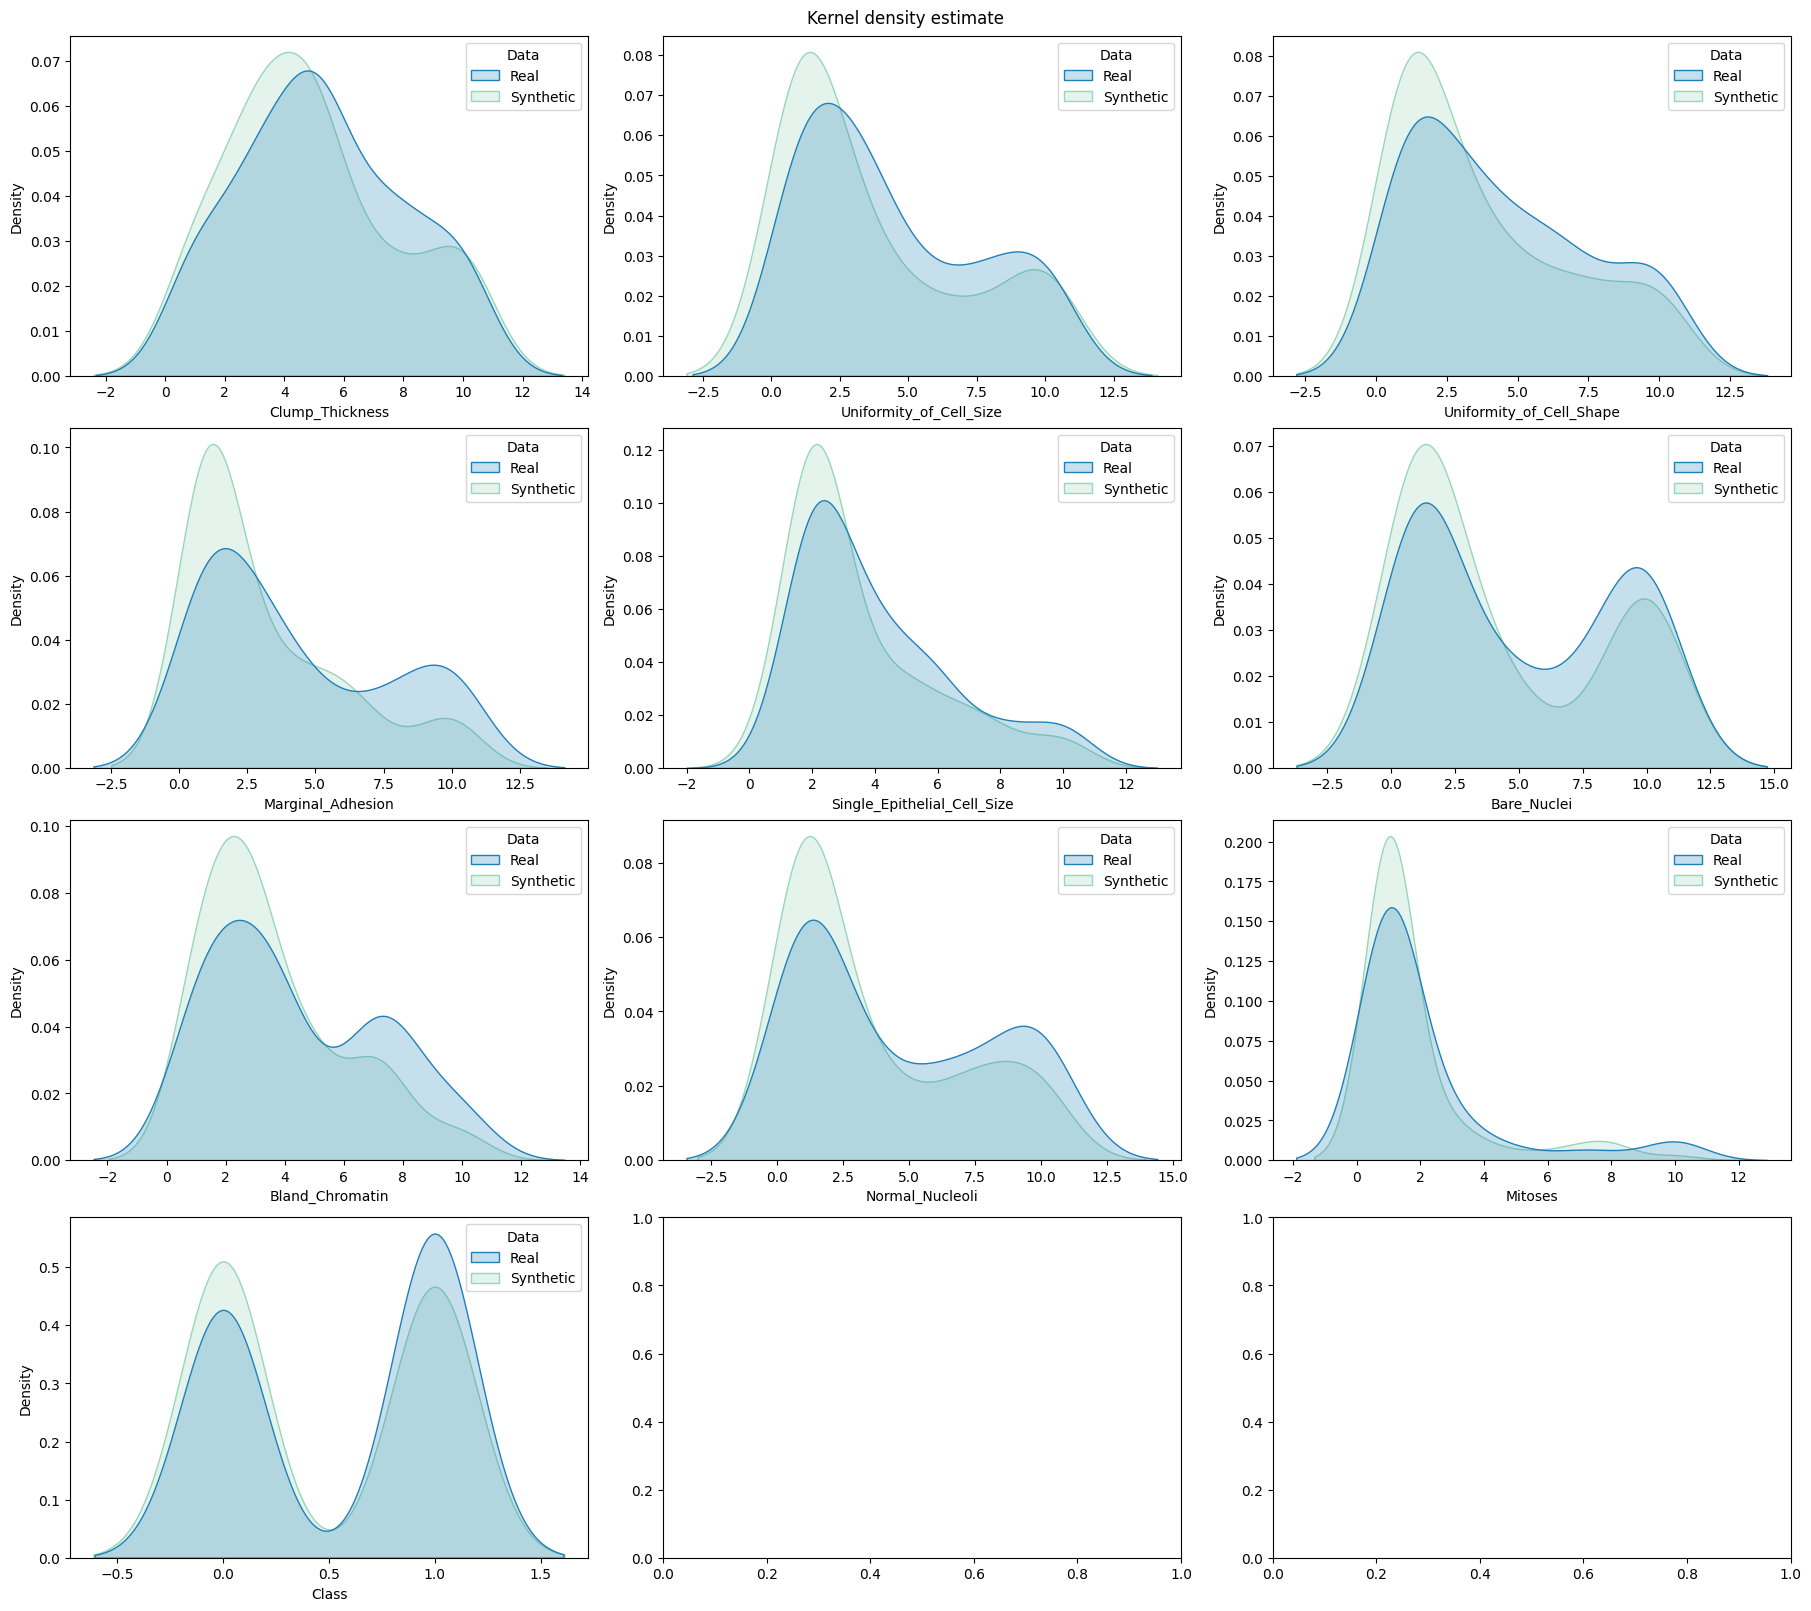

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(  # manually set number of cols/rows
    nrows=4, ncols=3, squeeze=0, figsize=(18, 16), layout="constrained"
)
axes = axes.reshape(-1)
utils.draw.kde_plot_hue_plot_per_col(
    df=df_real["test"],
    df_nested=df_synth["test"],
    original_name="Real",
    nested_name="Synthetic",
    hue_name="Data",
    title="Kernel density estimate",
    axes=axes,
)

## Generate the utility report

Some metrics will not be computed since the only categorical variable is the variable to predict 

## 1. First option: Create and compute the full utility report - it takes some time

In [6]:
report = UtilityReport(
    dataset_name="Wisconsin Breast Cancer Dataset",
    df_real=df_real,
    df_synthetic=df_synth,
    metadata=metadata,
    figsize=(8, 6),  # will be automatically adjusted for larger or longer figures
    random_state=0,  # for reproducibility purposes
    report_filepath=None,  # load a computed report if available
    metrics=None,  # list of the metrics to compute. If not specified, all the metrics are computed.
    cross_learning=True,  # not parallelized yet, can be set to False if the computation is too slow. See the use_gpu flag to accelerate the computation
    num_repeat=1,  # for the metrics relying on predictions to account for randomness
    num_kfolds=3,  # the number of folds to tune the hyperparameters for the metrics relying on predictors
    num_optuna_trials=20,  # the number of trials of the optimization process for tuning hyperparameters for the metrics relying on predictors
    use_gpu=True,  # run the learning tasks on the GPU
    alpha=0.05,  # for the pairwise chi-square metric
)

In [7]:
report.compute()

## Get the summary report as a pandas dataframe

In [8]:
report.specification()

----- Wisconsin Breast Cancer Dataset -----
Contains:
    - 359 instances in the train set,
    - 90 instances in the test set,
    - 10 variables, 9 continuous and 1 categorical.


In [9]:
df_summary = report.summary()

In [10]:
by = ["name", "objective", "min", "max"]
df_summary.groupby(by).apply(lambda x: x.drop(by, axis=1).reset_index(drop=True))

alias  \
name                                          objective min max                            
Categorical Consistency                       max       0   1.0 0             cat_consis   
Categorical Statistics                        max       0   1.0 0              cat_stats   
                                                                1              cat_stats   
Classification                                min       0   1.0 0                classif   
Continuous Consistency                        max       0   1.0 0            cont_consis   
Continuous Statistics                         min       0   inf 0             cont_stats   
                                                                1             cont_stats   
Cross Classification                          min       0   1.0 0          cross_classif   
Cross Regression                              min       0   inf 0              cross_reg   
Distinguishability                            min       0   1.0 0                   dist   
                                                                1                   dist   
                                                                2                   dist   
                                                                3                   dist   
FScore                                        min       0   inf 0                 fscore   
Feature Importance                            min       0   inf 0            feature_imp   
Hellinger Categorical Univariate Distance     min       0   1.0 0     hell_cat_univ_dist   
Hellinger Continuous Univariate Distance      min       0   1.0 0    hell_cont_univ_dist   
KL Divergence Categorical Univariate Distance min       0   inf 0   kl_div_cat_univ_dist   
KL Divergence Continuous Univariate Distance  min       0   inf 0  kl_div_cont_univ_dist   
Pairwise Correlation Difference               min       0   inf 0                    pcd   

                                                                                     submetric  \
name                                          objective min max                                  
Categorical Consistency                       max       0   1.0 0                 within_ratio   
Categorical Statistics                        max       0   1.0 0             support_coverage   
                                                                1           frequency_coverage   
Classification                                min       0   1.0 0              diff_real_synth   
Continuous Consistency                        max       0   1.0 0                 within_ratio   
Continuous Statistics                         min       0   inf 0           median_l1_distance   
                                                                1              iqr_l1_distance   
Cross Classification                          min       0   1.0 0              diff_real_synth   
Cross Regression                              min       0   inf 0              diff_real_synth   
Distinguishability                            min       0   1.0 0               prediction_mse   
                                                                1          prediction_mse_real   
                                                                2         prediction_mse_synth   
                                                                3      prediction_auc_rescaled   
FScore                                        min       0   inf 0                 diff_f_score   
Feature Importance                            min       0   inf 0  diff_permutation_importance   
Hellinger Categorical Univariate Distance     min       0   1.0 0           hellinger_distance   
Hellinger Continuous Univariate Distance      min       0   1.0 0           hellinger_distance   
KL Divergence Categorical Univariate Distance min       0   inf 0                kl_divergence   
KL Divergence Continuous Univariate Distance  min       0   inf 0                kl_divergence   


## Display the detailed report

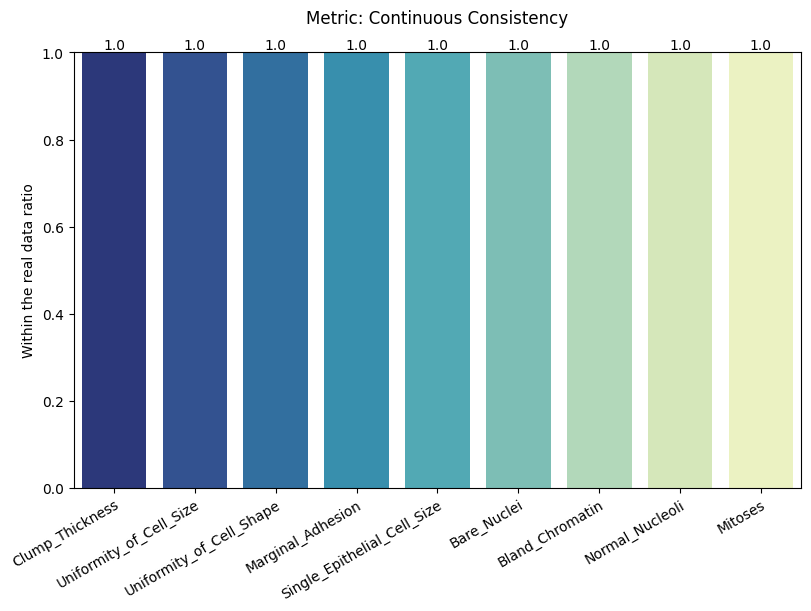

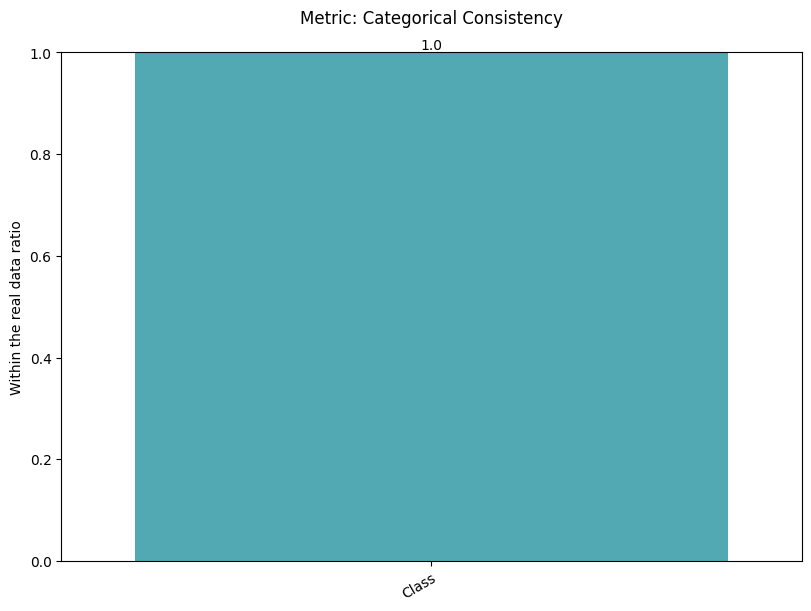

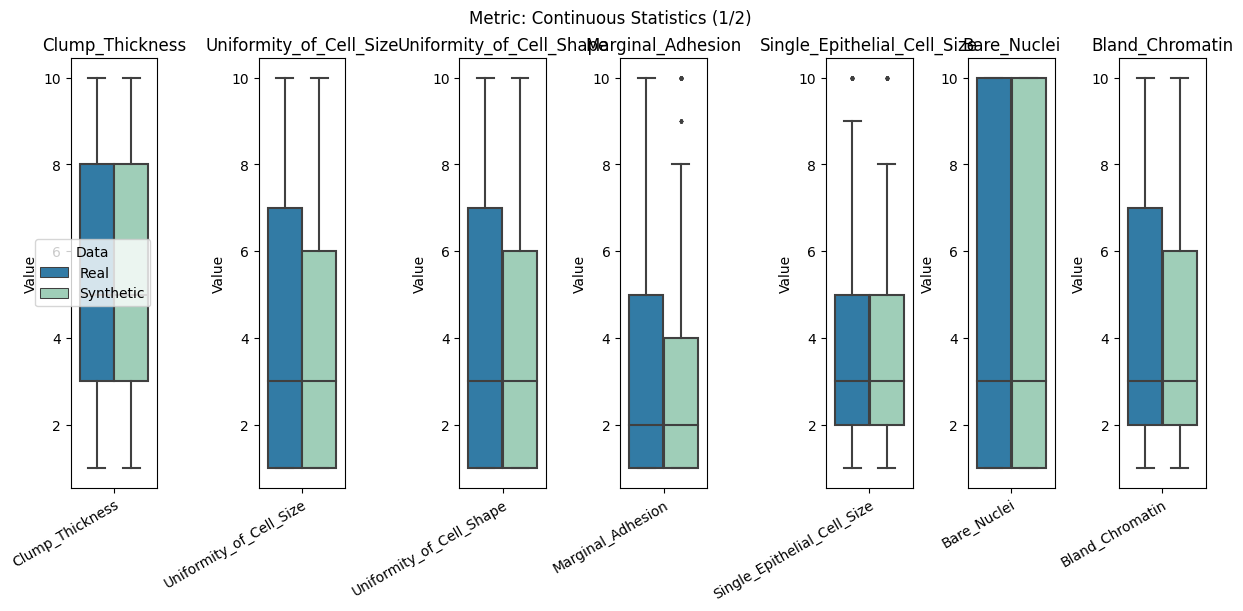

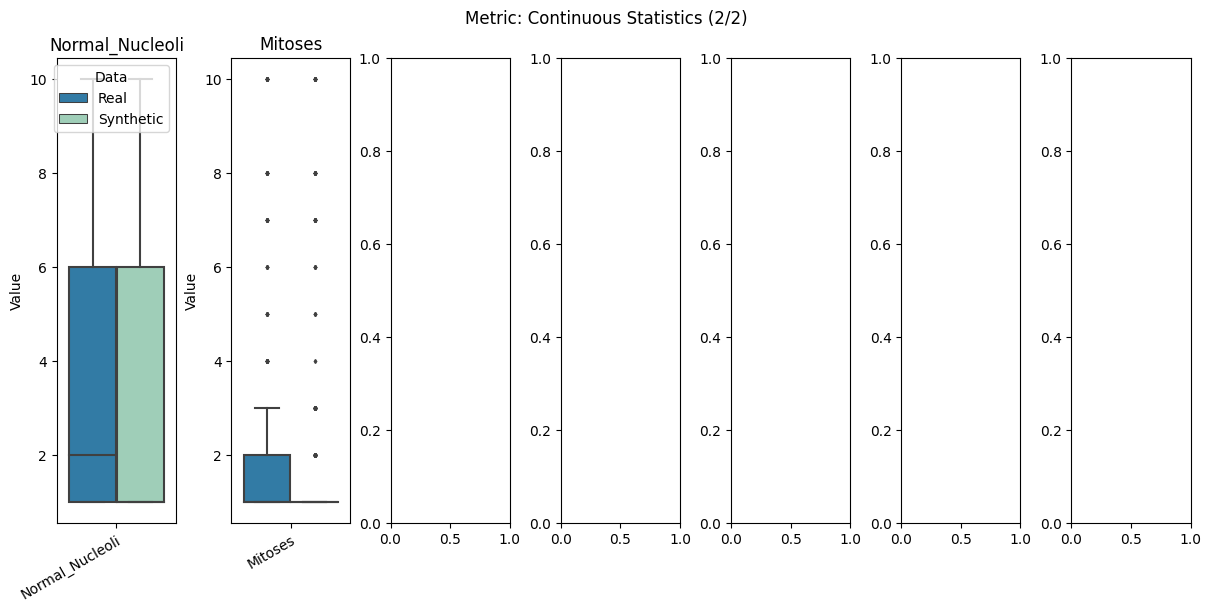

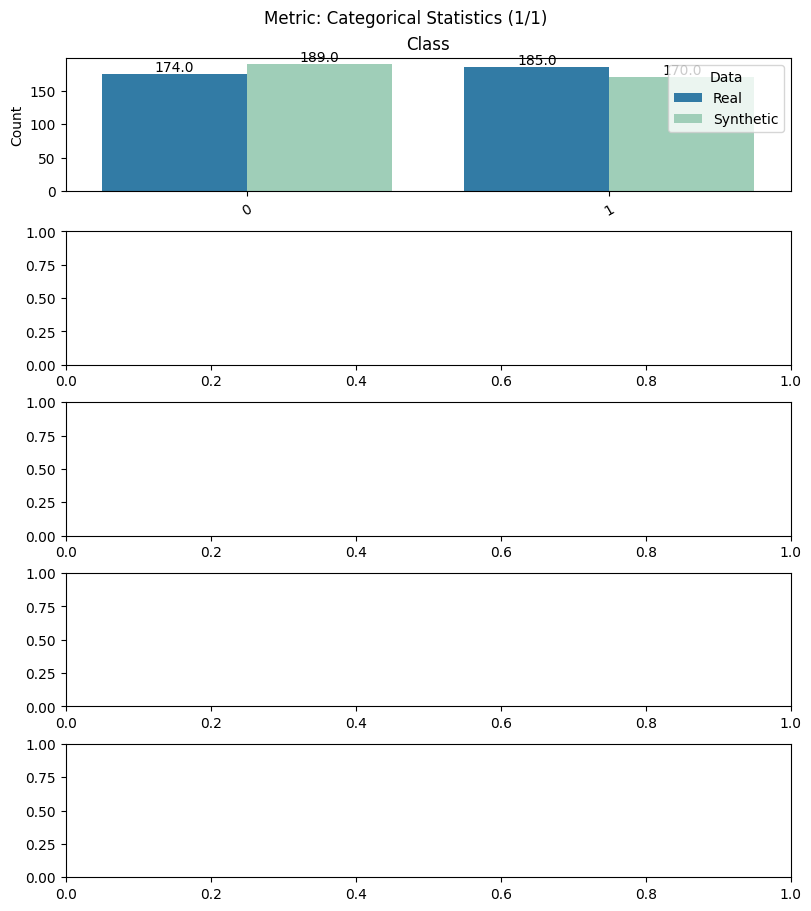

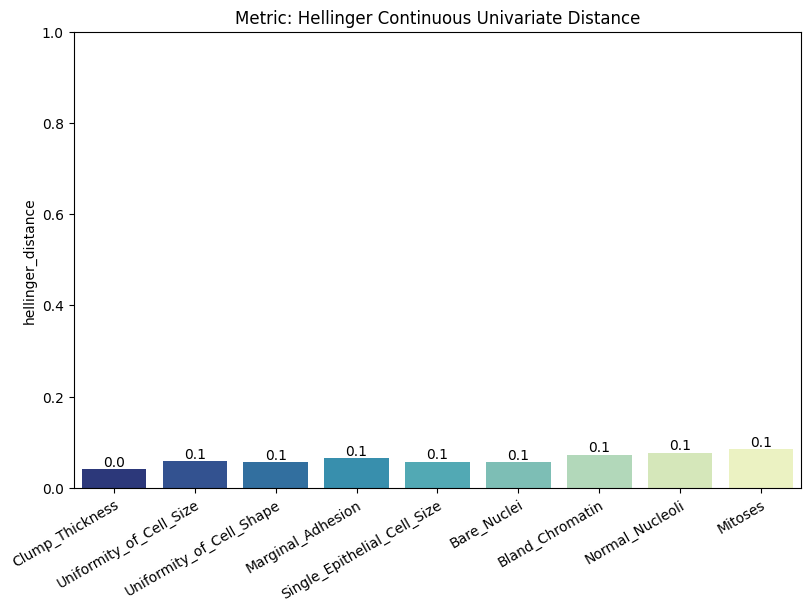

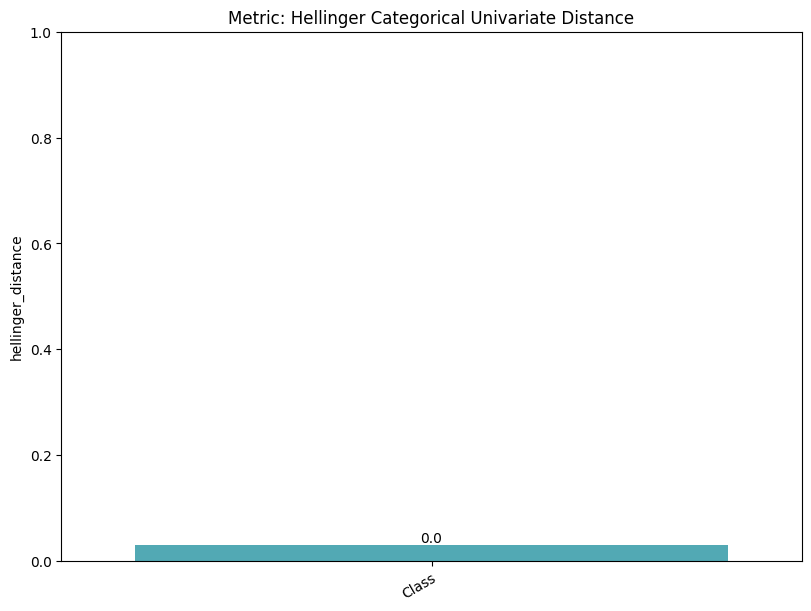

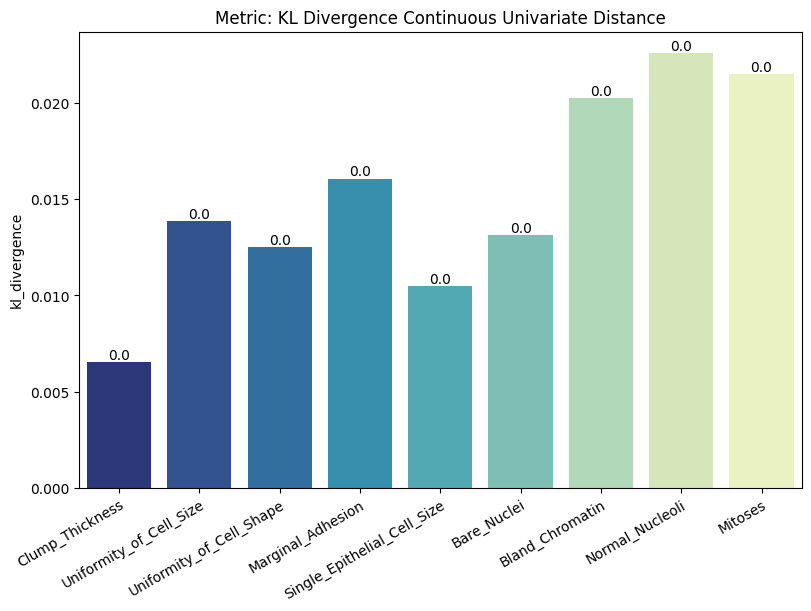

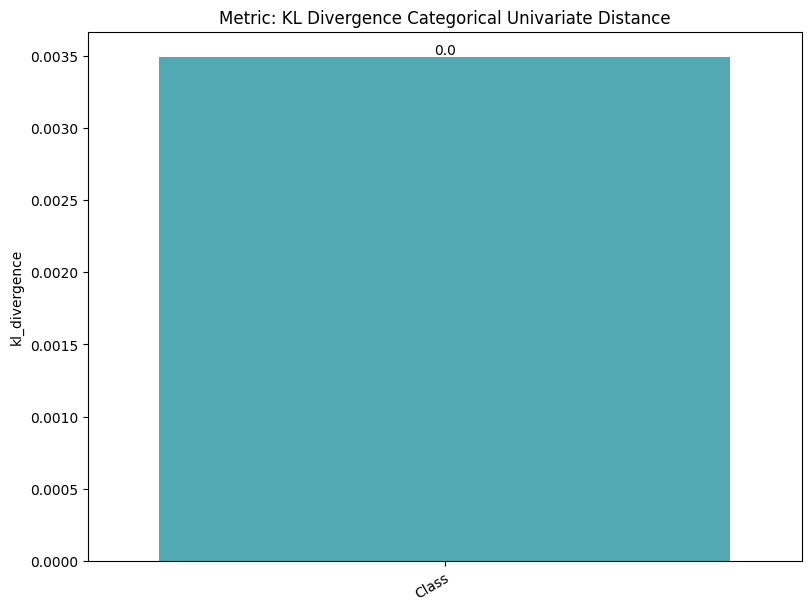

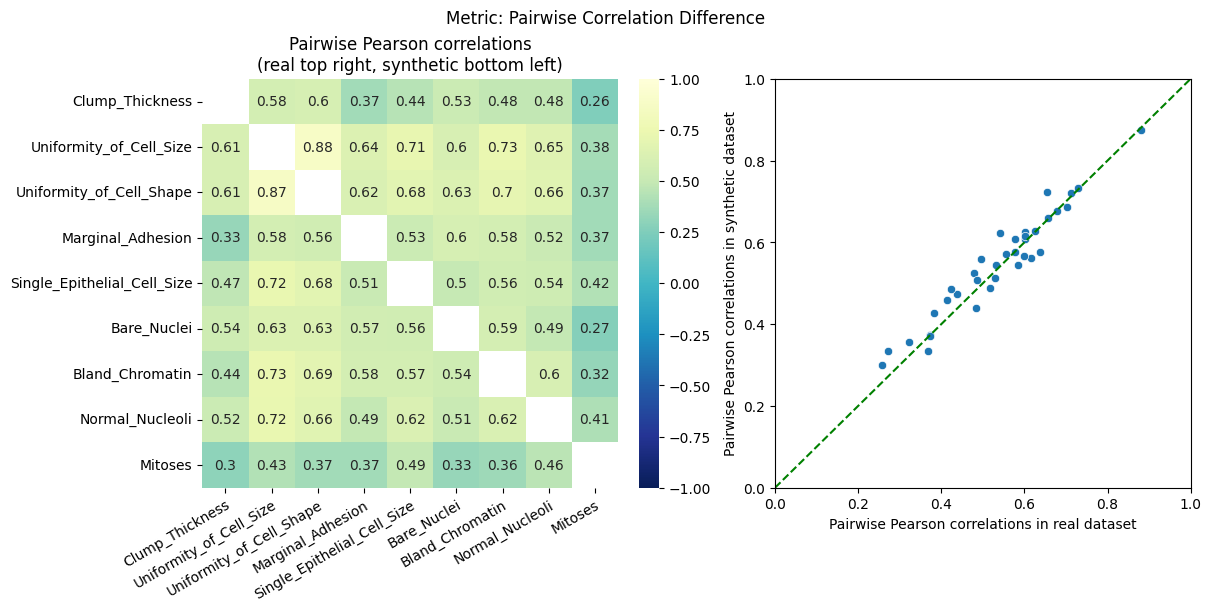

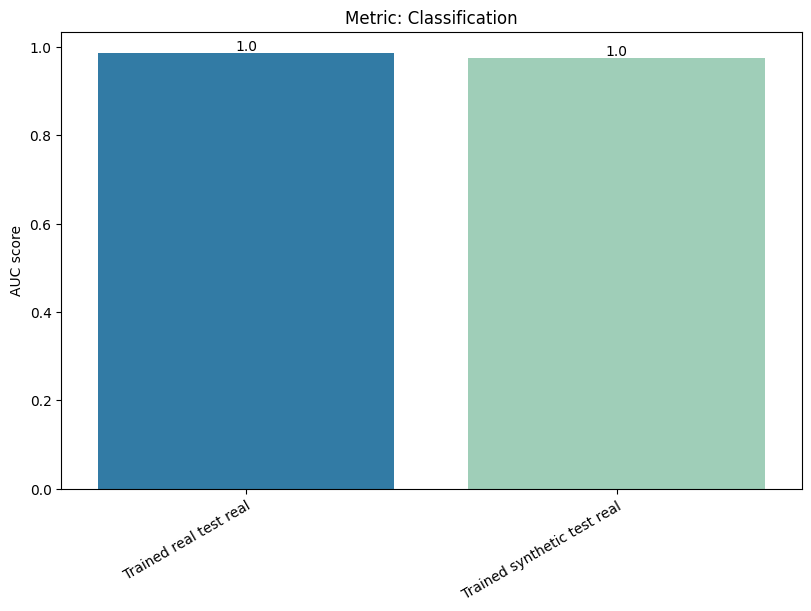

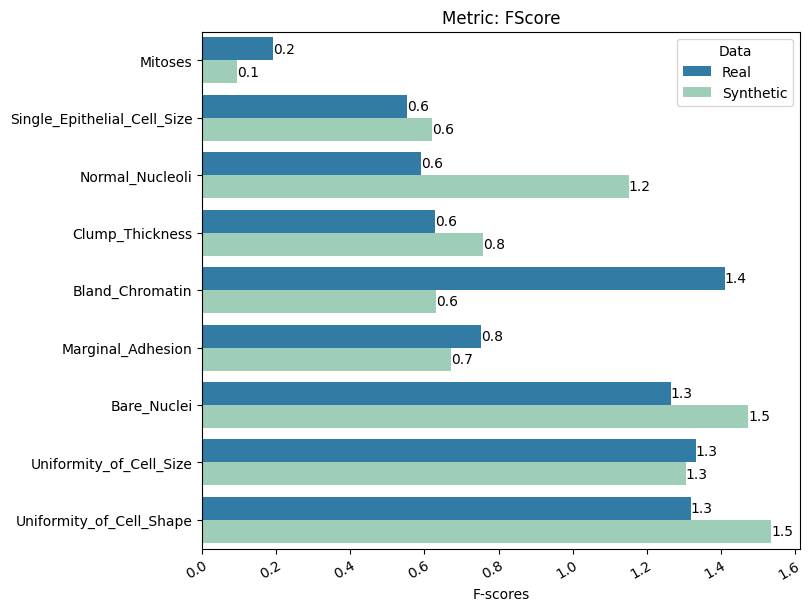

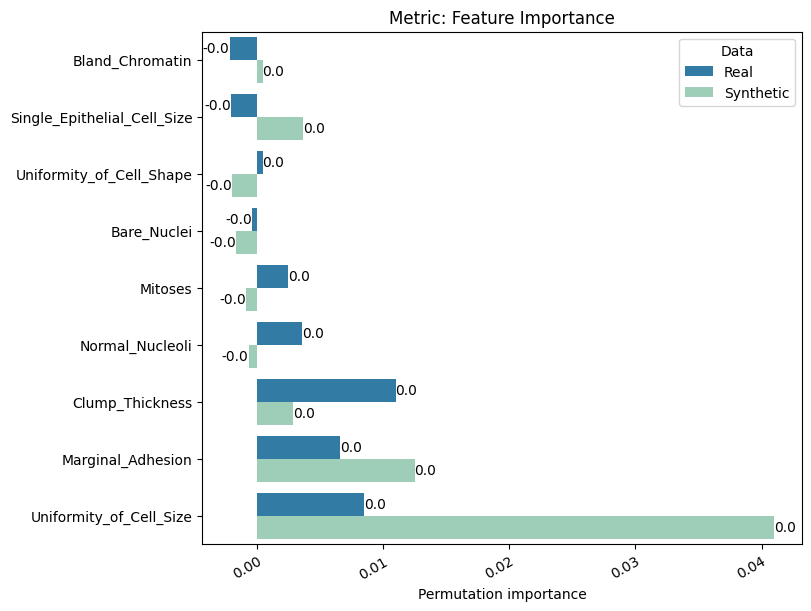

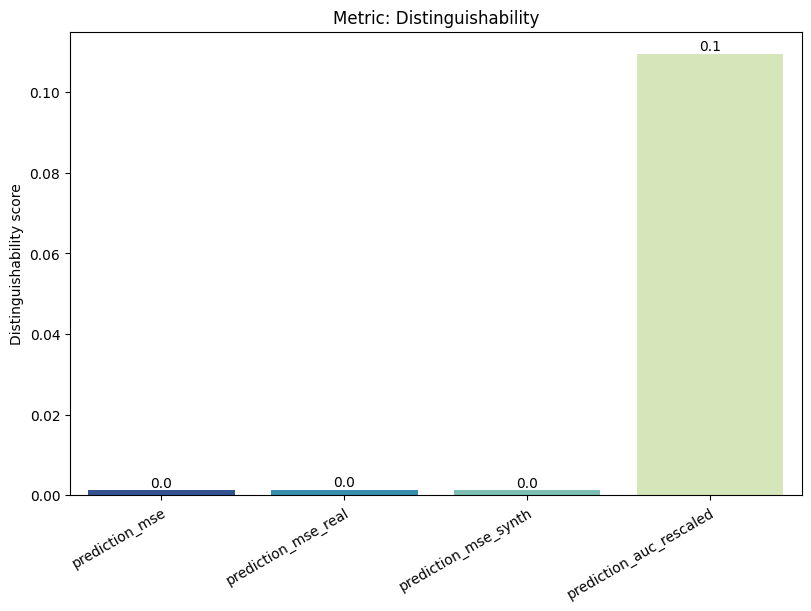

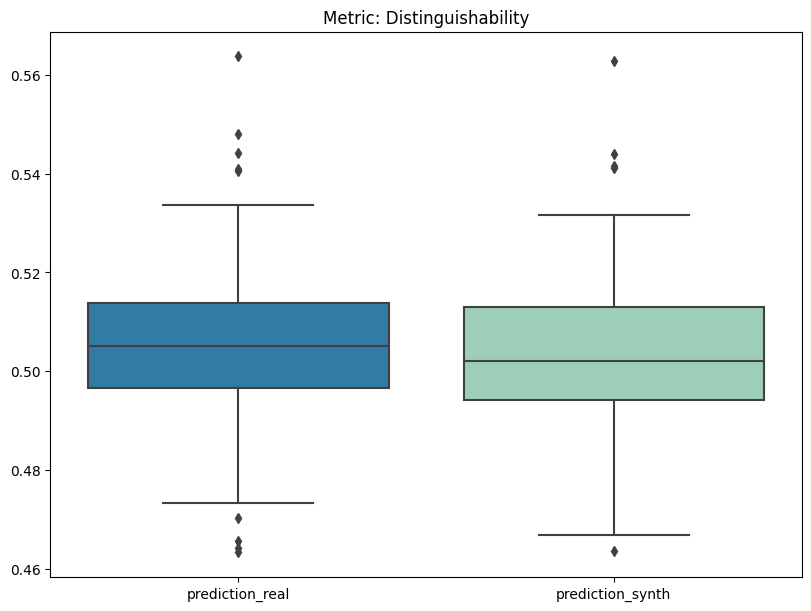

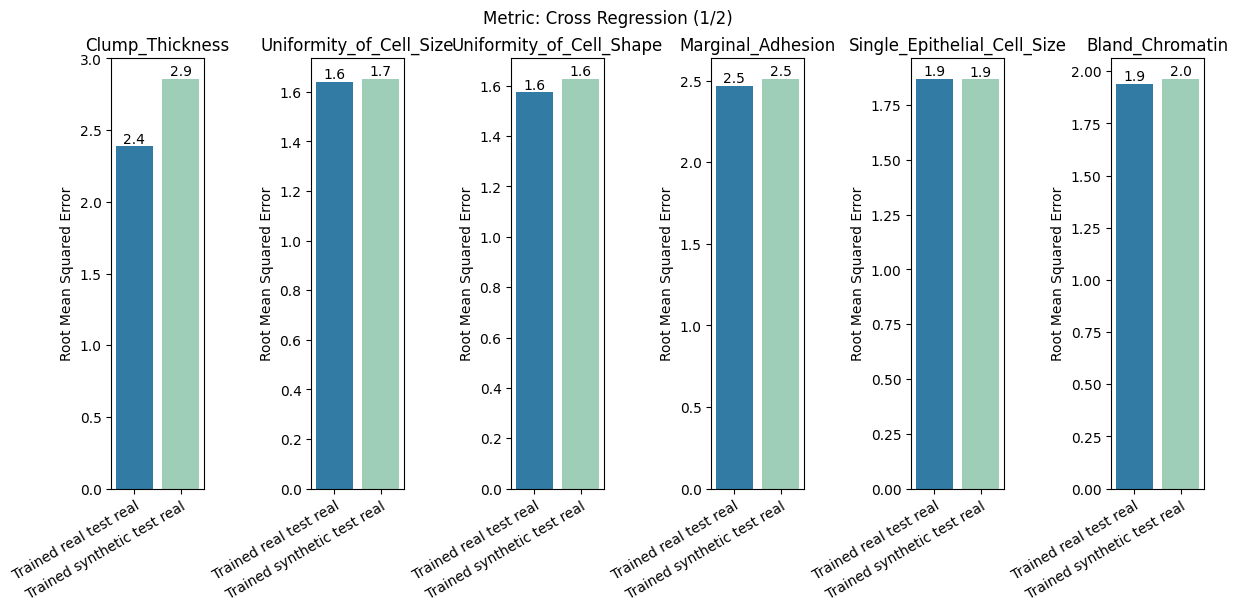

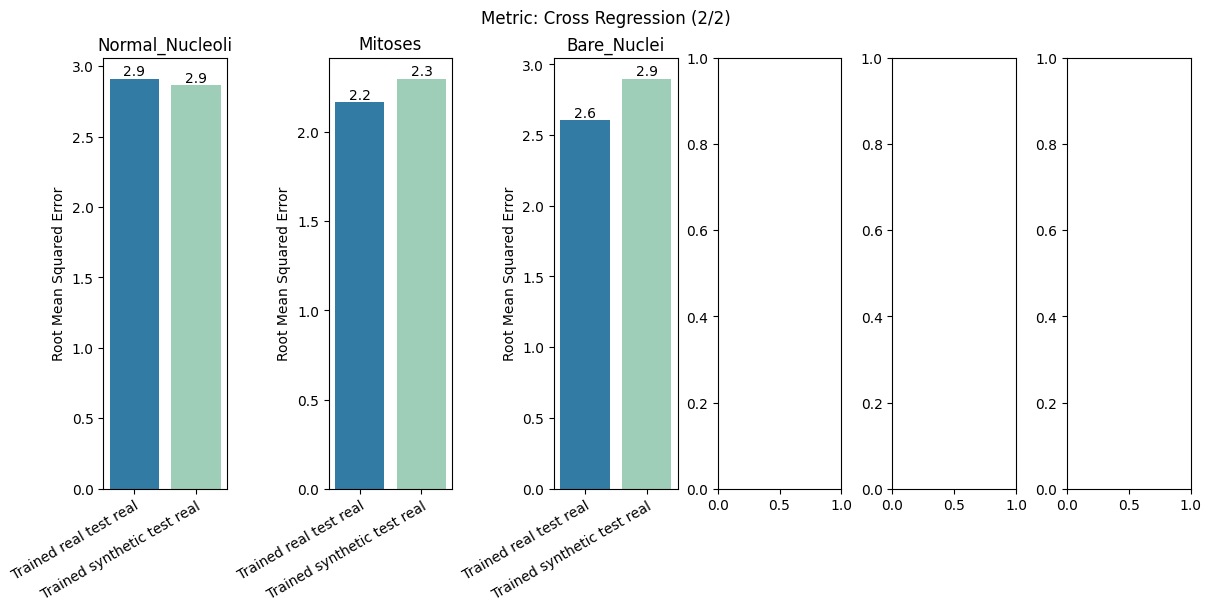

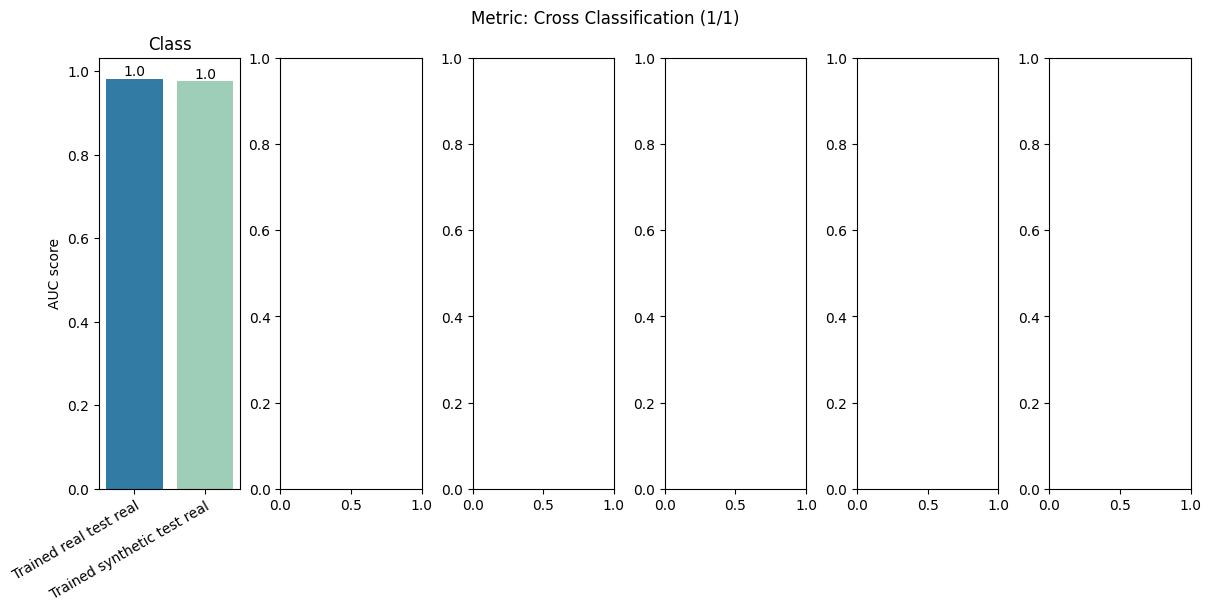

In [11]:
report.detailed(show=True, save_folder=None, figure_format="png")

### To display only one metric, the draw function can be used.

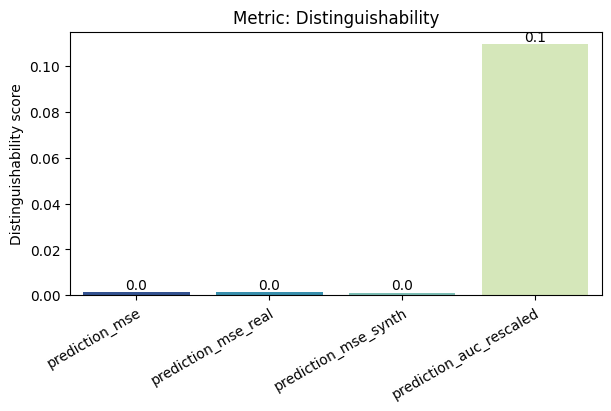

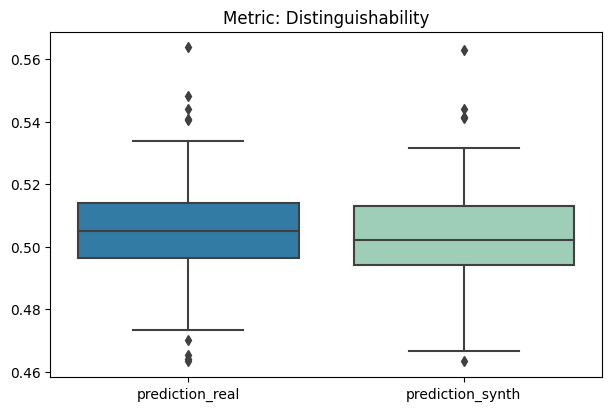

In [12]:
report.draw(
    metric_name="Distinguishability",
    figsize=(
        6,
        4,
    ),  # Reset here the size of the figure if it was too small in the report
    show=True,
    save_folder=None,
    figure_format="png",
)

## Save and load the report

In [13]:
with tempfile.TemporaryDirectory() as temp_dir:
    report.save(savepath=temp_dir, filename="utility_report")  # save
    new_report = UtilityReport(
        report_filepath=Path(temp_dir) / "utility_report.pkl"
    )  # load

## 2. Second option: Create and compute the report for a subset of metrics only

### Here only compute the Distinguishability metric

In [14]:
report = UtilityReport(
    dataset_name="Wisconsin Breast Cancer Dataset",
    df_real=df_real,
    df_synthetic=df_synth,
    metadata=metadata,
    metrics=["Distinguishability"],  # the subset of metrics to compute
    num_repeat=2,
    num_kfolds=3,
    num_optuna_trials=20,
    use_gpu=False,  # if a GPU is available, it will accelerate the computation
    alpha=0.05,
)

In [15]:
report.compute()

In [16]:
report.summary()

,name,alias,submetric,value,objective,min,max
0,Distinguishability,dist,prediction_mse,0.009470,min,0,1.0
1,Distinguishability,dist,prediction_mse_real,0.009290,min,0,1.0
2,Distinguishability,dist,prediction_mse_synth,0.009650,min,0,1.0
3,Distinguishability,dist,prediction_auc_rescaled,0.087222,min,0,1.0


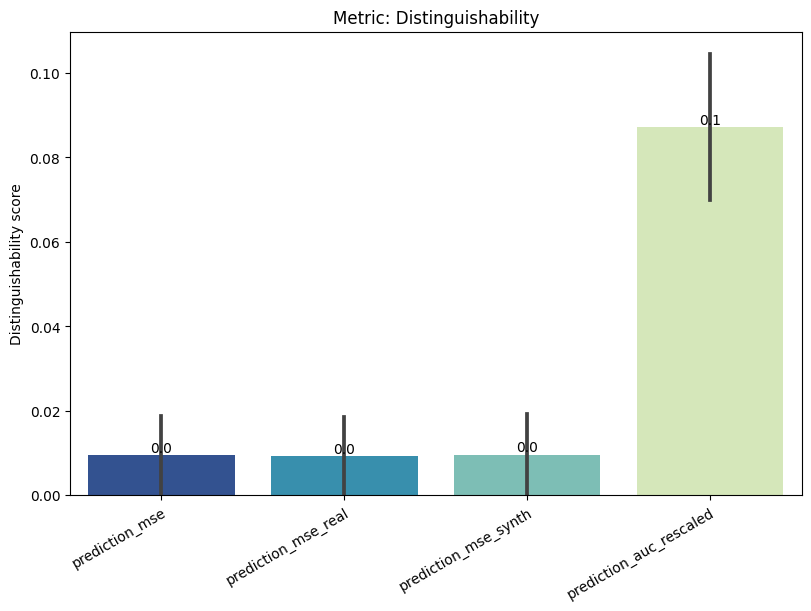

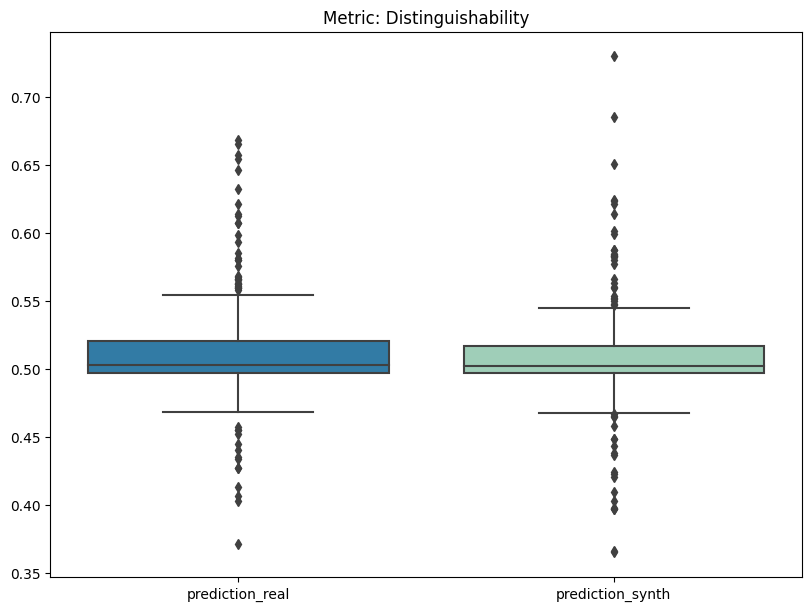

In [17]:
report.detailed(show=True, save_folder=None, figure_format="png")